# Preclustering and Cluster Enriched Features

## Purpose
The purpose of this step is to perform a simple pre-clustering using the highly variable features to get a pre-clusters labeling. We then select top enriched features for each cluster (CEF) for further analysis.

## Input
- HVF adata file.

## Output
- HVF adata file with pre-clusters and CEF annotated.

## Import

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import numpy as np
from ALLCools.clustering import cluster_enriched_features, significant_pc_test, log_scale, balanced_pca, tsne
from ALLCools.plot import categorical_scatter

In [2]:
sns.set_context(context='notebook', font_scale=1.3)

## Parameters

In [6]:
cell_metadata_path = 'CellMetadata.PassQC.csv.gz'
cluster_adata_path = 'adata.with_coords.h5ad'
ch_adata_path = 'mCH.HVF.h5ad'
cg_adata_path = 'mCG.HVF.h5ad'

# Cluster Enriched Features analysis
top_n=200
alpha=0.05
stat_plot=True

# you may provide a pre calculated cluster version. 
# If None, will perform basic clustering using parameters below.
cluster_col = 'L1'
p_cutoff = 0.1

## Load Data

In [4]:
adata = anndata.read_h5ad(cluster_adata_path)
ch_adata = anndata.read_h5ad(ch_adata_path)
cg_adata = anndata.read_h5ad(cg_adata_path)

## Cluster Enriched Features (CEF)

### mCH

Found 29 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values
Selected 2965 unique features


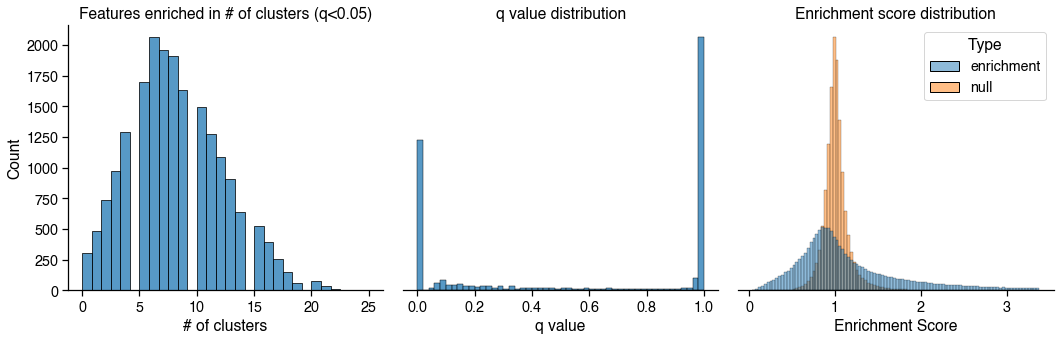

In [5]:
ch_adata.obs[cluster_col] = adata.obs[cluster_col]
cluster_enriched_features(ch_adata,
                          cluster_col=cluster_col,
                          top_n=top_n,
                          alpha=alpha,
                          stat_plot=True)

### mCG

Found 29 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values
Selected 2652 unique features


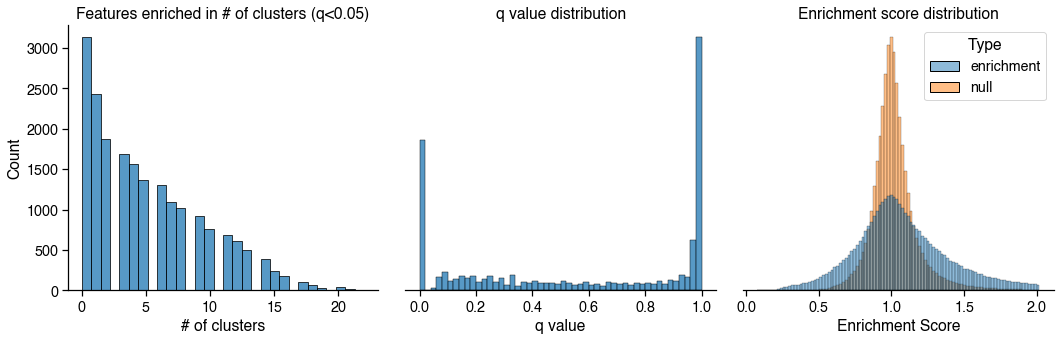

In [6]:
cg_adata.obs[cluster_col] = adata.obs[cluster_col]
cluster_enriched_features(cg_adata,
                          cluster_col=cluster_col,
                          top_n=top_n,
                          alpha=alpha,
                          stat_plot=True)

## Save AnnData

In [7]:
# save adata
ch_adata.write_h5ad(ch_adata_path)
cg_adata.write_h5ad(cg_adata_path)

# save CEF ids
with open(f'{cluster_col}_enriched_features.mCH.txt', 'w') as f:
    features = ch_adata.var_names[ch_adata.var[f'{cluster_col}_enriched_features']]
    f.write('\n'.join(features))
with open(f'{cluster_col}_enriched_features.mCG.txt', 'w') as f:
    features = cg_adata.var_names[cg_adata.var[f'{cluster_col}_enriched_features']]
    f.write('\n'.join(features))

## PCA

### mCH

In [16]:
# using Cluster Enriched Features
ch_adata = ch_adata[:, ch_adata.var[f'{cluster_col}_enriched_features']].copy()
# scale
log_scale(ch_adata)
# PCA
balanced_pca(ch_adata, groups=cluster_col)
# Select significant PCs
ch_n_components = significant_pc_test(ch_adata, p_cutoff=p_cutoff)

25 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (4958, 200) to (4958, 25)


### mCG

In [17]:
# using Cluster Enriched Features
cg_adata = cg_adata[:, cg_adata.var[f'{cluster_col}_enriched_features']].copy()
# scale
log_scale(cg_adata)
# PCA
balanced_pca(cg_adata, groups=cluster_col)
# Select significant PCs
cg_n_components = significant_pc_test(cg_adata, p_cutoff=p_cutoff)

15 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (4958, 200) to (4958, 15)


### Concatenate

In [18]:
ch_pcs = ch_adata.obsm['X_pca'][:, :ch_n_components]
cg_pcs = cg_adata.obsm['X_pca'][:, :cg_n_components]

# scale the PCs so CH and CG PCs has the same total var
cg_pcs = cg_pcs / cg_pcs.std()
ch_pcs = ch_pcs / ch_pcs.std()

# total_pcs
total_pcs = np.hstack([ch_pcs, cg_pcs])
adata.obsm['X_pca'] = total_pcs

## Manifold Learning

In [19]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return adata

### tSNE

In [20]:
tsne(adata,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)
dump_embedding(adata, 'tsne')

AnnData object with n_obs × n_vars = 4958 × 2869
    obs: 'leiden', 'mCHFrac', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'L1', 'L1_proba', 'CellTypeAnno'
    var: 'chrom', 'bin_start', 'bin_end', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select', 'leiden_enriched_features', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'leiden_feature_enrichment', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

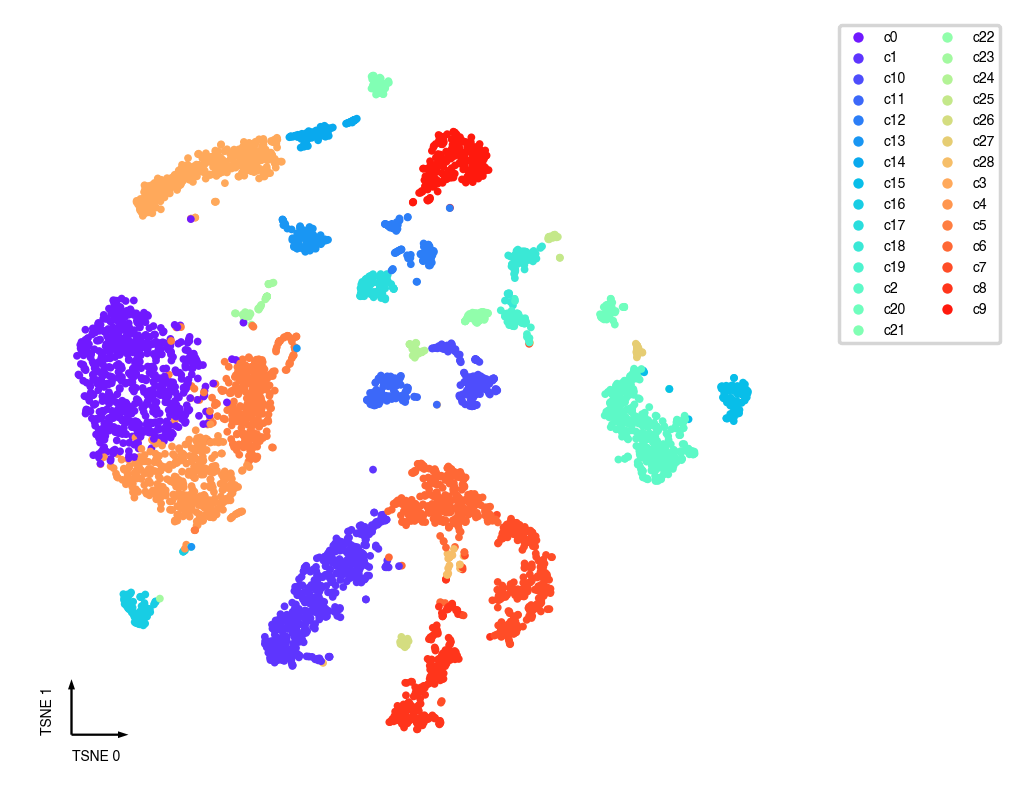

In [21]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata.obs, ax=ax, coord_base='tsne', hue=cluster_col, show_legend=True)

### UMAP

In [22]:
sc.pp.neighbors(adata)
try:
    sc.tl.paga(adata, groups=cluster_col)
    sc.pl.paga(adata, plot=False)
    sc.tl.umap(adata, init_pos='paga')
except:
    sc.tl.umap(adata)
dump_embedding(adata, 'umap')

AnnData object with n_obs × n_vars = 4958 × 2869
    obs: 'leiden', 'mCHFrac', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'L1', 'L1_proba', 'CellTypeAnno'
    var: 'chrom', 'bin_start', 'bin_end', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select', 'leiden_enriched_features', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'leiden_feature_enrichment', 'leiden_sizes', 'neighbors', 'paga', 'umap', 'L1_sizes'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

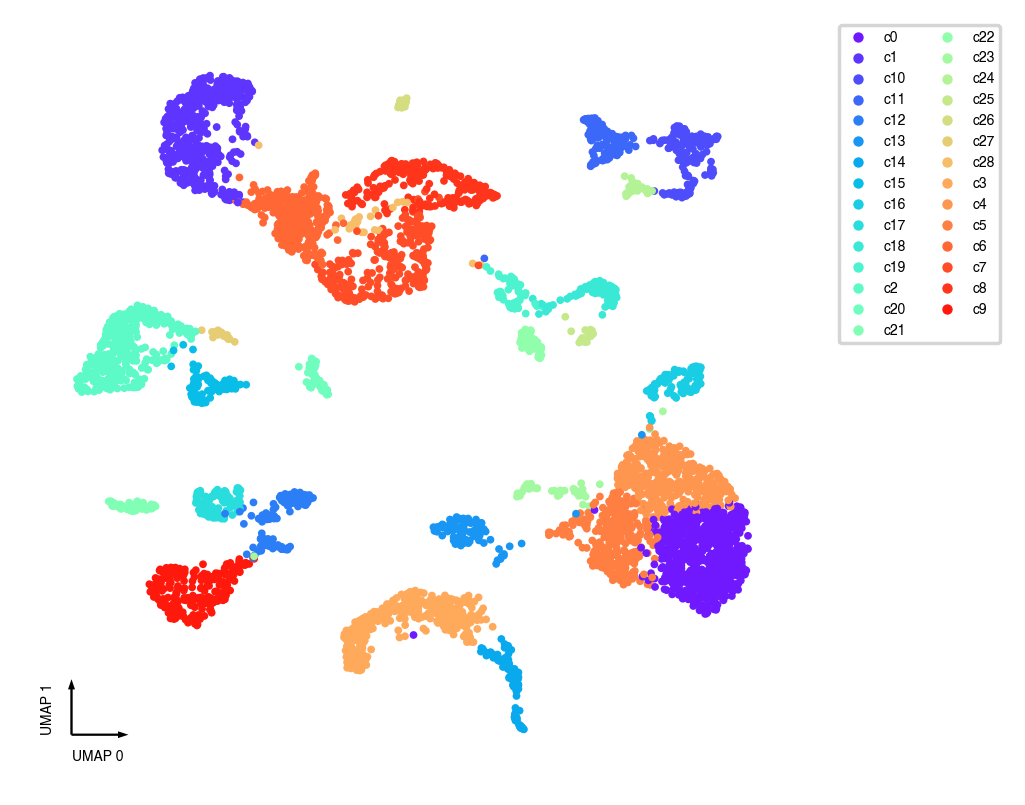

In [23]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata.obs, ax=ax, coord_base='umap', hue=cluster_col, show_legend=True)

## Save

In [24]:
adata.write_h5ad('adata.with_coords.h5ad')
adata

AnnData object with n_obs × n_vars = 4958 × 2869
    obs: 'leiden', 'mCHFrac', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'L1', 'L1_proba', 'CellTypeAnno'
    var: 'chrom', 'bin_start', 'bin_end', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select', 'leiden_enriched_features', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'leiden_feature_enrichment', 'leiden_sizes', 'neighbors', 'paga', 'umap', 'L1_sizes'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [13]:
# save final clustering result table
cell_meta = pd.read_csv(cell_metadata_path, index_col=0)
final_result = pd.concat([cell_meta, adata.obs], axis=1)
final_result.to_csv(f'{cluster_col}.ClusteringResults.csv.gz')
final_result.head()

,mCCCFrac,mCGFrac,mCHFrac,FinalmCReads,CellInputReadPairs,MappingRate,Plate,Col384,Row384,CellTypeAnno,leiden,mCHFrac,tsne_0,tsne_1,umap_0,umap_1,L1,L1_proba,CellTypeAnno
3C_M_0,0.00738,0.75953,0.02543,1195574.0,2896392,0.625773,CEMBA171206-3C-1,18,0,IT-L23,9,0.02543,-2.190700,-29.984436,-2.626835,16.946815,c1,0.889633,IT-L23
3C_M_1,0.00938,0.77904,0.03741,1355517.0,3306366,0.631121,CEMBA171206-3C-1,18,1,IT-L5,6,0.03741,32.138909,-33.795453,5.993103,11.156058,c7,0.836833,IT-L5
3C_M_10,0.00915,0.82430,0.03678,2815807.0,7382298,0.657560,CEMBA171206-3C-1,21,1,L6b,29,0.03678,47.848855,10.542578,-1.341150,8.590765,c27,0.963000,L6b
3C_M_100,0.00978,0.79705,0.04231,2392650.0,5865154,0.671600,CEMBA171206-3C-1,0,3,MGE-Pvalb,15,0.04231,2.193998,1.312017,12.358179,18.650204,c11,0.811733,MGE-Pvalb
3C_M_1000,0.00776,0.78781,0.02789,1922013.0,4800236,0.646285,CEMBA171206-3C-4,3,8,IT-L6,8,0.02789,9.249685,-56.862935,8.071514,14.603106,c8,0.783700,IT-L6
